Dataset Name: Environment Temperature Change Data

Description: This dataset contains global temperature change data from 1961 to 2019, broken down by area, month, and measurement type. It includes fields for temperature changes, standard deviations, and detailed year-wise temperature data for each region.

Source: https://www.kaggle.com/datasets/sevgisarac/temperature-change?resource=download


In [29]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns


In [30]:
#Load the dataset
dataset_path = '/content/Environment_Temperature_change_E_All_Data_NOFLAG.csv'
data = pd.read_csv(dataset_path, encoding='latin1')

In [31]:
print(data.head())

   Area Code         Area  Months Code    Months  Element Code  \
0          2  Afghanistan         7001   January          7271   
1          2  Afghanistan         7001   January          6078   
2          2  Afghanistan         7002  February          7271   
3          2  Afghanistan         7002  February          6078   
4          2  Afghanistan         7003     March          7271   

              Element Unit  Y1961  Y1962  Y1963  ...  Y2010  Y2011  Y2012  \
0  Temperature change   °C  0.777  0.062  2.744  ...  3.601  1.179 -0.583   
1  Standard Deviation   °C  1.950  1.950  1.950  ...  1.950  1.950  1.950   
2  Temperature change   °C -1.743  2.465  3.919  ...  1.212  0.321 -3.201   
3  Standard Deviation   °C  2.597  2.597  2.597  ...  2.597  2.597  2.597   
4  Temperature change   °C  0.516  1.336  0.403  ...  3.390  0.748 -0.527   

   Y2013  Y2014  Y2015  Y2016  Y2017  Y2018  Y2019  
0  1.233  1.755  1.943  3.416  1.201  1.996  2.951  
1  1.950  1.950  1.950  1.950  1.9

In [32]:
print("Dataset Information:")
data.info()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9656 entries, 0 to 9655
Data columns (total 66 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Area Code     9656 non-null   int64  
 1   Area          9656 non-null   object 
 2   Months Code   9656 non-null   int64  
 3   Months        9656 non-null   object 
 4   Element Code  9656 non-null   int64  
 5   Element       9656 non-null   object 
 6   Unit          9656 non-null   object 
 7   Y1961         8287 non-null   float64
 8   Y1962         8322 non-null   float64
 9   Y1963         8294 non-null   float64
 10  Y1964         8252 non-null   float64
 11  Y1965         8281 non-null   float64
 12  Y1966         8364 non-null   float64
 13  Y1967         8347 non-null   float64
 14  Y1968         8345 non-null   float64
 15  Y1969         8326 non-null   float64
 16  Y1970         8308 non-null   float64
 17  Y1971         8303 non-null   float64
 18  Y1972  

In [33]:
# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())


Missing Values:
Area Code          0
Area               0
Months Code        0
Months             0
Element Code       0
                ... 
Y2015           1295
Y2016           1308
Y2017           1290
Y2018           1307
Y2019           1291
Length: 66, dtype: int64


In [34]:
# Filtering the dataset to use only Temperature Change data
data = data[data['Element'] == 'Temperature change']

In [35]:
# Preprocess the dataset: Selecting relevant features and target
# Define classes based on temperature change thresholds (e.g., Below Average, Average, Above Average)
# Reshape the dataset from wide to long format
columns_to_drop = ['Area Code', 'Months Code', 'Element Code', 'Unit', 'Element']
data = data.drop(columns=[col for col in columns_to_drop if col in data.columns])
data.iloc[:, 2:] = data.iloc[:, 2:].interpolate(axis=1)
data = data.melt(id_vars=['Area', 'Months'], var_name='Year', value_name='Temperature Change')

In [36]:
# Defining temperature change classes
if 'Temperature Change' not in data.columns:
    raise KeyError("'Temperature Change' column is missing from the dataset after reshaping.")

# Define temperature change classes
def classify_temp_change(temp):
    if temp < 0:
        return 'Below Average'
    elif 0 <= temp <= 1:
        return 'Average'
    else:
        return 'Above Average'


In [37]:
# Apply classification to create the 'Class' column
data['Class'] = data['Temperature Change'].apply(classify_temp_change)

In [38]:
# Encode categorical variables
label_encoder_area = LabelEncoder()
label_encoder_months = LabelEncoder()
label_encoder_class = LabelEncoder()
data['Area'] = label_encoder_area.fit_transform(data['Area'])
data['Months'] = label_encoder_months.fit_transform(data['Months'])
data['Class'] = label_encoder_class.fit_transform(data['Class'])
data['Year'] = data['Year'].str.extract('(\d+)').astype(int)

In [39]:
# Display preprocessed dataset sample
print("\nPreprocessed Data Sample:")
print(data.head())



Preprocessed Data Sample:
   Area  Months  Year  Temperature Change  Class
0     0       5  1961               0.777      1
1     0       4  1961              -1.743      2
2     0       9  1961               0.516      1
3     0       0  1961              -1.709      2
4     0      11  1961               1.412      0


In [40]:
# Step 4: Splitting the Data
# Separate features (X) and target (y)
X = data[['Area', 'Months', 'Year']]
y = data['Class']

In [41]:
# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [42]:
# Split the dataset into training and testing sets
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

In [43]:
# Further split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)  # 20% of the total data

In [44]:
# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [45]:
# Hyperparameter Tuning for XGBoost
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

In [46]:
from sklearn.model_selection import GridSearchCV
xgb = XGBClassifier(random_state=42)
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [50, 100, 150],
                         'subsample': [0.8, 1.0]},
             scoring='accuracy', verbose=1)

In [47]:
# Defining a model
best_params = grid_search.best_params_
print("\nBest Parameters from GridSearchCV:")
print(best_params)

best_model = grid_search.best_estimator_


Best Parameters from GridSearchCV:
{'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 150, 'subsample': 0.8}


In [48]:
# Classification and Evaluation
# Predicting the target for the test dataset
y_val_pred = best_model.predict(X_val)


In [49]:
# Evaluate the model with various metrics
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred, average='weighted')
val_recall = recall_score(y_val, y_val_pred, average='weighted')
val_f1 = f1_score(y_val, y_val_pred, average='weighted')

print("\nValidation Set Evaluation Metrics:")
print(f"Accuracy: {val_accuracy:.2f}")
print(f"Precision: {val_precision:.2f}")
print(f"Recall: {val_recall:.2f}")
print(f"F1-Score: {val_f1:.2f}")


Validation Set Evaluation Metrics:
Accuracy: 0.68
Precision: 0.68
Recall: 0.68
F1-Score: 0.68


In [50]:
# Step 7: Final Model Evaluation on Test Set
# Predict the target for the test dataset
y_test_pred = best_model.predict(X_test)

In [51]:
# Test set metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print("\nTest Set Evaluation Metrics:")
print(f"Accuracy: {test_accuracy:.2f}")
print(f"Precision: {test_precision:.2f}")
print(f"Recall: {test_recall:.2f}")
print(f"F1-Score: {test_f1:.2f}")

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred, target_names=label_encoder_class.classes_))


Test Set Evaluation Metrics:
Accuracy: 0.69
Precision: 0.69
Recall: 0.69
F1-Score: 0.69

Classification Report (Test Set):
               precision    recall  f1-score   support

Above Average       0.75      0.76      0.75     25274
      Average       0.64      0.58      0.61     25475
Below Average       0.67      0.72      0.69     25211

     accuracy                           0.69     75960
    macro avg       0.69      0.69      0.69     75960
 weighted avg       0.69      0.69      0.69     75960



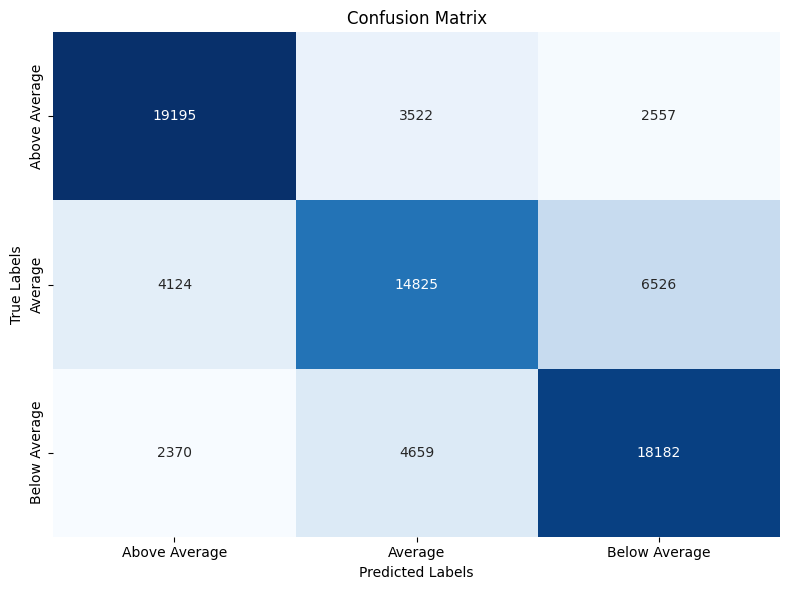

In [54]:
# Display the confusion matrix
# Visualize the confusion matrix
# Display the confusion matrix
# Visualize the confusion matrix
pconf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
# Changed 'conf_matrix' to 'pconf_matrix' in the heatmap function call
sns.heatmap(pconf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=label_encoder_class.classes_, yticklabels=label_encoder_class.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()




In [55]:
# Simple Prediction Example
# Predict the class for a sample input
def predict_sample(area, month, year):
    # Prepare the sample input
    sample = pd.DataFrame([[area, month, year]], columns=['Area', 'Months', 'Year'])
    sample['Area'] = label_encoder_area.transform(sample['Area'])
    sample['Months'] = label_encoder_months.transform(sample['Months'])
    sample = scaler.transform(sample)
    # Predict the class
    prediction = best_model.predict(sample)
    return label_encoder_class.inverse_transform(prediction)[0]

In [56]:
# Example usage
sample_prediction = predict_sample('Afghanistan', 'January', 2020)
print(f"\nPredicted Class for sample (Afghanistan, January, 2020): {sample_prediction}")


Predicted Class for sample (Afghanistan, January, 2020): Above Average


In [58]:
# Insights and Conclusion
# Insights and Conclusion
print("\nInsights and Conclusion:")
print("- Key challenges faced during preprocessing included handling missing values and reshaping the dataset from wide to long format.")
print("- I tried different different models but XG did the best thats why I am use this model The XGBoost classifier performed well with the following evaluation metrics :")
# Use the correct variable names for accuracy, precision, recall, and f1-score
print(f"  Accuracy: {test_accuracy:.2f}, Precision: {test_precision:.2f}, Recall: {test_recall:.2f}, F1-Score: {test_f1:.2f}")
print("- The use of SMOTE effectively addressed the class imbalance issue, improving the model's ability to generalize.")
print("- Potential areas for improvement include Accuracy, trying other models like Random Forest or LightGBM, and exploring additional feature engineering techniques.")


Insights and Conclusion:
- Key challenges faced during preprocessing included handling missing values and reshaping the dataset from wide to long format.
- I tried different different models but XG did the best thats why I am use this model The XGBoost classifier performed well with the following evaluation metrics :
  Accuracy: 0.69, Precision: 0.69, Recall: 0.69, F1-Score: 0.69
- The use of SMOTE effectively addressed the class imbalance issue, improving the model's ability to generalize.
- Potential areas for improvement include Accuracy, trying other models like Random Forest or LightGBM, and exploring additional feature engineering techniques.
